## Estimating house 🏠 prices 💸 in Iowa's (USA) Ames residential area
#### Manual ML ✍️ approach

#### Goal:
to estimate house prices using the Random Forest regressor

#### Data:
Ames house features and prices, originally prepared by Dean De Cock, later modified by Kaggle. Data are accessible at: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

#### Processing steps:
1. Downloading the source data using Kaggle API and unzipping it
2. Loading the training part into Pandas 
3. Exploratory Data Analysis (EDA)
4. Source data pre-processing
5. Hyperparameter tuning
6. Evaluating the final model on test data

#### Sources: 
[1] Kaggle API usage advices: https://stackoverflow.com/questions/55934733/documentation-for-kaggle-api-within-python <br>
[2] Medium article "Why “1.5” in IQR Method of Outlier Detection?": https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097 <br>
[3] "Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems" by Aurélien Géron <br>

### Step 0: importing packages

In [43]:
import copy
import os
import zipfile

from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

### Step 1: Downloading the source data using Kaggle API and unzipping it

As the first step, we need to create the Kaggle account and download the Kaggle API token following instructions in [1]. Then we are ready to download the source data using the API: 

In [ ]:
api = KaggleApi()

In [ ]:
api.authenticate()

In [2]:
competition_name = 'house-prices-advanced-regression-techniques'

In [ ]:
api.competition_download_files(competition_name)

The downloaded *.zip* file can be unzipped with the code:

In [ ]:
with zipfile.ZipFile(competition_name + '.zip', 'r') as zip_ref:
    zip_ref.extractall(competition_name)

### Step 2: Loading the training part into Pandas

Let's check what is included in the unzipped folder:

In [3]:
for entry in os.scandir(competition_name):
    if entry.is_file():
        print(entry.name)

sample_submission.csv
data_description.txt
test.csv
train.csv


... and open the prepared training file:

In [4]:
train_df = pd.read_csv(os.path.join(competition_name, 'train.csv'))

In [5]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Step 3: Exploratory Data Analysis (EDA)

<b> 3.1. Understanding the meaning of the explanatory features </b>

The definition of each column's name as well as all unique values the feature can take, can be checked in the *data_description.txt* file. After the analysis of the file I came to the following conclusions:

- features can be grouped according to their thematic meaning:
    - physical properties of the plot
    - surrounding's properties
    - building's exterior characteristics
    - building's interior (rooms') characteristics
    - features characterizing the garden
    - sale details
- many elements (roof, bathroom, garden etc.) are described in great detail, with separate characteristics for different aspects like the type, condition and quality of the element
- location-related features e.g. *Condition1: Proximity to various conditions* (park, railroad) are, in my subjective opinion, covered in the lowest degree; moreover their values are defined indirectly as categories; additonally each house can be characterized with only one or two values of such features; using a direct form of location (lat, lon) and combining it with land cover maps would allow to describe location-related characteristic of the house more precisely
- many of the features could potentially be automatically collected/updated using remote sensing data

<b> 3.2. Checking the training dataset's size, as well as the type and the number of missing values for each feature </b>

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Using the *info()* method allows to observe that:
- the training dataset consists of 1460 samples (houses) - it is therefore rather small 
- the dataset includes both numeric (dtypes *int64* and *float64*) and categorical (dtype *object*) features
- features are characterized by different amount of missing values, with the highest number of them observed for categorical features

In [7]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


The *describe()* method provides summary statistics for numeric features. We can observe that values characterizing each feature are defined using their 'original' scale i.e. they are not normalized or standardized. 

<b> 3.3. Finding potential outliers and analyzing statistical distributions </b>

By looking at *min* and *max* statistics, we can also check whether the numeric features have any potential outlier values. Outliers can simply be defined as "data points which differs significantly from other observations" [2]. Their occurence in the dataset may be a result of an error in data collection/measurement/processing (artificial outliers) or a natural dataset's characteristic (true outlier). The extreme values of the dataset:
- fall within the range of values defined in *'data_description.txt'* e.g. *'MSSubClass'* or *'OverallCond'* <br>
or 
- are related to area/length/number of element and have realistic values e.g. *'LotArea'* or *'BsmtFullBath'* <br>
or 
- contain a year when something important for the property happened and have realistic values - *'YearBuilt'* <br>

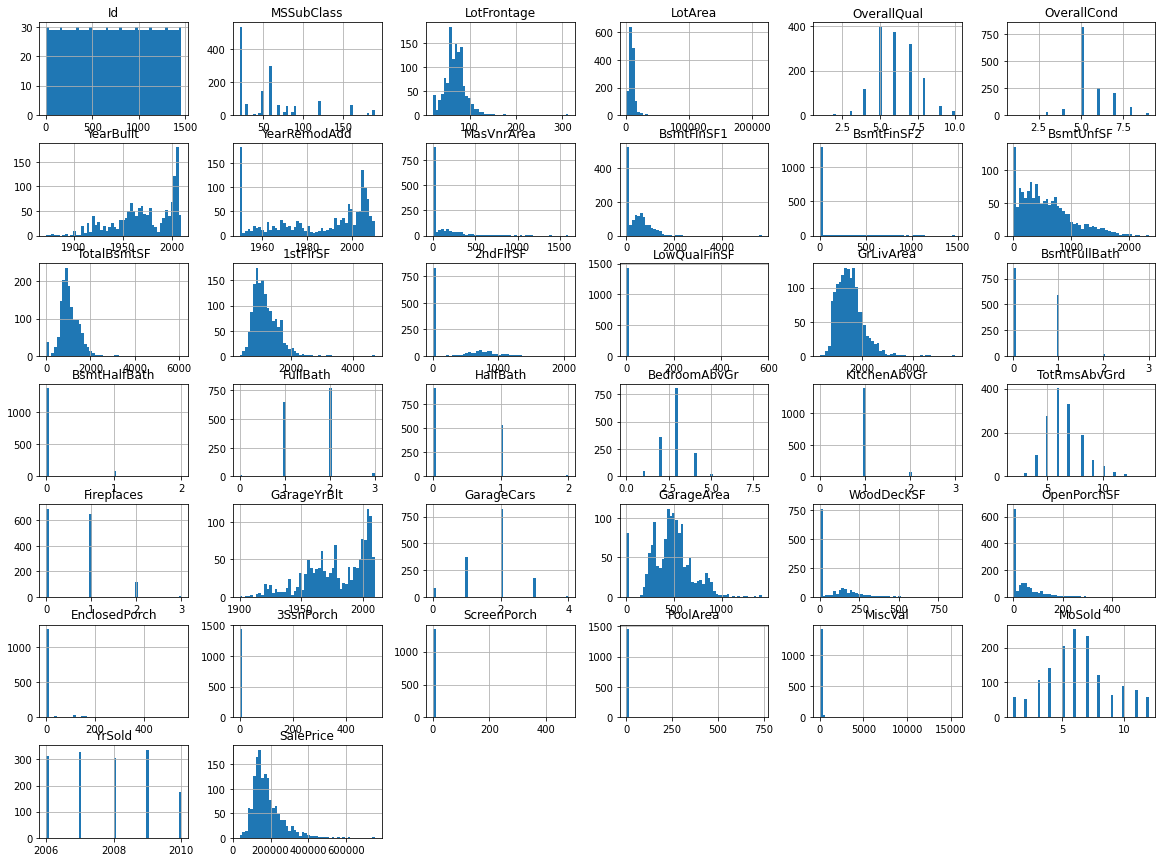

In [8]:
train_df.hist(bins=50, figsize=(20,15));

The analysis of the histograms allows to observe that selected features are characterized by the presence of values far from the mean. Their distribution is often other than normal. Finally, some features related to area e.g. *'BsmtFinSF1'* or *'GarageArea'* have a lot of values equal to 0 meaning 'no such area'. Because of this reasons and the fact that the dataset is rather small, a stratified sampling approach to train-val split should be considered at later stages. 

<b> 3.4. Calculating correlation between features </b>

In the next step we can calculate correlation between different features included in the dataset. The conclusions of such an analysis can help during future train-val sampling and feature selection steps:

In [9]:
def plot_heatmap(input_df, corr_method='spearman'):
    """Return a heatmap of correlation values between features included in the input pd.DataFrame."""
    corr_matrix = train_df.corr(method=corr_method)
    
    plt.figure(figsize = (10,10))
    plt.imshow(corr_matrix, cmap ="coolwarm", vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=270)
    plt.yticks(range(len(corr_matrix)), corr_matrix.index)
    plt.show();

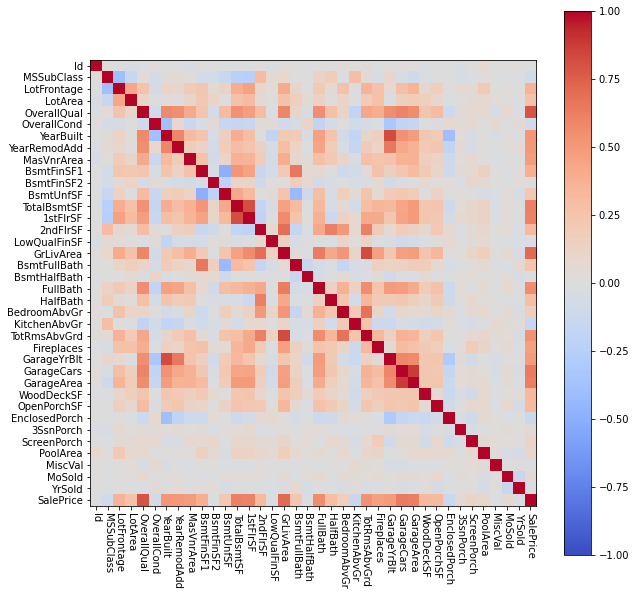

In [10]:
plot_heatmap(input_df=train_df, corr_method='pearson')

We can observe the following:
- the target feature *'SalePrice'* is strongly positively correlated with *'OverallQual'* and to a lesser extent also with *'GrLivArea'*, *'GarageCars'* and *'GarageArea'*; additionally, it does not have a strong negative correlation with any of the explanatory features
- several features describing different areal and time-related characteristics of house elements are linearly correlated with each other e.g. *'YearBuilt'* and *'GarageYrBlt'*
- one explanatory feature - *'Enclosed'* seems to be descibing the changing fashion for the houses as it is negatively correlated with *'YearBuilt'*
- there are features which are not correlated with any other feature; these include *'OverallCond'*, as well as features describing porch, pool and selling process

<b> 3.5. Reducing dimensionality - analyzing relationships between houses visually </b>

In [11]:
def plot_tsne_2d(input_df, target_name, cmap="coolwarm", figsize = (10,10)):
    """Return a scatter plot for 2 t-SNE components, coloured by the target values."""
    
    # preparing data
    input_num_df = input_df.select_dtypes(include=['int', 'float'])
    input_num_df = input_num_df.dropna()
    print(f"The number of samples left is: {input_num_df.shape[0]}")
    target_df = input_num_df[[target_name]]
    features_num_np = input_num_df.drop(target_name, axis=1).to_numpy()
    
    # applying t-SNE to the data
    features_embedded_np = TSNE().fit_transform(features_num_np)
    
    # plotting
    features_embedded_df = pd.DataFrame(features_embedded_np, columns =['tSNE_comp1', 'tSNE_comp2']) 
    merged_df = pd.concat([features_embedded_df, target_df], axis=1)
    
    plt.figure(figsize = figsize)
    plt.scatter(x=merged_df['tSNE_comp1'], y=merged_df['tSNE_comp2'], c=merged_df[target_name], cmap=cmap, alpha=0.7)
    cbar = plt.colorbar()
    cbar.set_label('SalePrice', rotation=270)
    plt.xticks()
    plt.xlabel('tSNE_comp1')
    plt.yticks()
    plt.ylabel('tSNE_comp2')
    plt.show();

The number of samples left is: 1121


/home/CENAGIS/aradecka/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/CENAGIS/aradecka/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


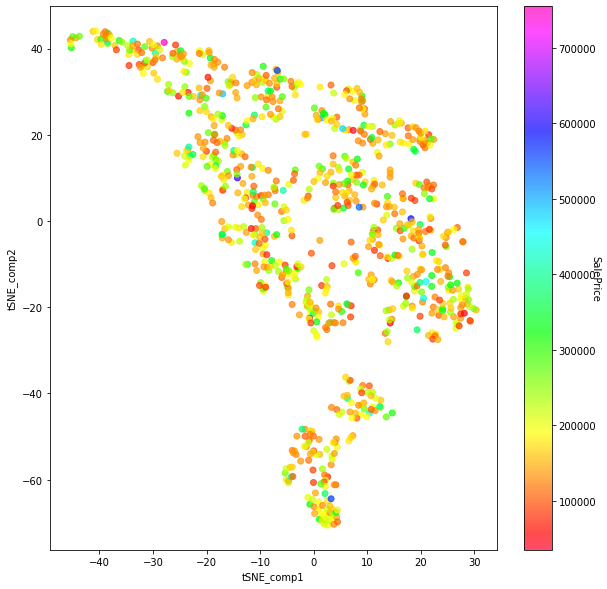

In [12]:
plot_tsne_2d(input_df=train_df, target_name='SalePrice', cmap='gist_rainbow')

We can conclude that houses do not form any specific clusters - there are no clear "house types". 

### Step 4: Source data pre-processing

- removing unnecessary columns

In [13]:
train_df = train_df.drop('Id', axis=1)

- features/labels split

In [14]:
X_train_df = train_df.drop('SalePrice', axis=1)
y_train_df = train_df[['SalePrice']]

- features pre-processing (following [3])

In [15]:
num_features = list(X_train_df.select_dtypes(include=['int', 'float']).columns)

In [16]:
cat_features = list(X_train_df.select_dtypes(exclude=['int', 'float']).columns)

In [17]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('oh_encoder', OneHotEncoder(handle_unknown='ignore')),
])

In [18]:
full_pipeline = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_features), 
    ('cat', cat_pipeline, cat_features),
])

In [19]:
X_train_prepared = full_pipeline.fit_transform(X_train_df)

I omitted scaling as Random Forest algorithm is not sensitive to this.

### Step 5: Hyperparameter tuning

In [20]:
param_grid = [
    {'n_estimators': list(range(10, 100, 10)), 'min_samples_split': [2, 4, 6]}
]

In [21]:
regr = RandomForestRegressor()

In [22]:
grid_search = GridSearchCV(regr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True) 
# negative MSE to indicate "the lower the better"

In [25]:
grid_search.fit(X_train_prepared.toarray(), y_train_df.to_numpy().ravel())
# X processed to transform sparse matrix > dense matrix, y processed to transform df > numpy matrix without second size dimension 

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'min_samples_split': [2, 4, 6],
                          'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80,
                                           90]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [27]:
grid_search.best_estimator_

RandomForestRegressor(min_samples_split=4, n_estimators=90)

In [34]:
cv_results = grid_search.cv_results_

In [36]:
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']): # folllowing [3]
    print(np.sqrt(-mean_score), params)

32472.748019703817 {'min_samples_split': 2, 'n_estimators': 10}
30697.89580366324 {'min_samples_split': 2, 'n_estimators': 20}
30122.366439486243 {'min_samples_split': 2, 'n_estimators': 30}
30486.462849951677 {'min_samples_split': 2, 'n_estimators': 40}
30162.15912543352 {'min_samples_split': 2, 'n_estimators': 50}
30471.542867554133 {'min_samples_split': 2, 'n_estimators': 60}
30957.40976918441 {'min_samples_split': 2, 'n_estimators': 70}
30385.253568582128 {'min_samples_split': 2, 'n_estimators': 80}
30705.79662189841 {'min_samples_split': 2, 'n_estimators': 90}
31171.37238829241 {'min_samples_split': 4, 'n_estimators': 10}
31615.727158100948 {'min_samples_split': 4, 'n_estimators': 20}
31002.649225747435 {'min_samples_split': 4, 'n_estimators': 30}
30959.977081073906 {'min_samples_split': 4, 'n_estimators': 40}
30467.687534563574 {'min_samples_split': 4, 'n_estimators': 50}
30129.315464002175 {'min_samples_split': 4, 'n_estimators': 60}
30728.75394736874 {'min_samples_split': 4, 'n

The result seem not to be influenced by '*mean_samples_split*'. On the contrary, '*n_estimator*' does influence it - on average, the higher the number of trees, the better the accuracy.

### Step 6: Evaluating the final model on test data 

In [38]:
test_df = pd.read_csv(os.path.join(competition_name, 'test.csv'))

In [39]:
X_test_df = test_df.drop('Id', axis=1)

In [40]:
X_test_prepared = full_pipeline.transform(X_test_df)

In [41]:
preds_rf = grid_search.best_estimator_.predict(X_test_prepared)

In [42]:
preds_rf

array([129149.44797178, 152751.08994709, 179959.65449735, ...,
       154862.639903  , 112204.91190476, 227382.50497355])

In [44]:
preds_rf_df = copy.deepcopy(test_df)
preds_rf_df['SalePrice'] = list(preds_rf)
preds_rf_df = preds_rf_df[['Id', 'SalePrice']]
preds_rf_df.to_csv('test_predictions_rf.csv', index=False)

<img src="image/kaggle_rf.jpg" width="700"/> 

As expected, manual approach resulted in worse performance on the test set, as compared to AutoML approach's results.  